In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io import fits
from astropy import wcs
from matplotlib.colors import LogNorm
from astropy.coordinates import Angle
from astropy import units as ut
import xml.etree.ElementTree as ET
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, LSR,HeliocentricMeanEcliptic
from matplotlib.gridspec import GridSpec
from astropy.convolution import Gaussian1DKernel, convolve
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.integrate import trapz
from scipy.ndimage import zoom
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from astropy.visualization.wcsaxes import SphericalCircle
import scipy as sp
from importlib import reload
import glob

In [3]:
import sys,os
import radiative_transfer
import read_GASKAP_data as rd

In [4]:
datapathbase='/d/bip5/hchen'

# Gaussian_fitting

BIC  1270.3029990707184 n=1
BIC  85.3774494714628 n= 2
BIC  86.639393683985 n= 3
final n= 2.0 6.965345312584754 [False False] [28.51005964 12.04730398]
BIC= 85.37749364409144


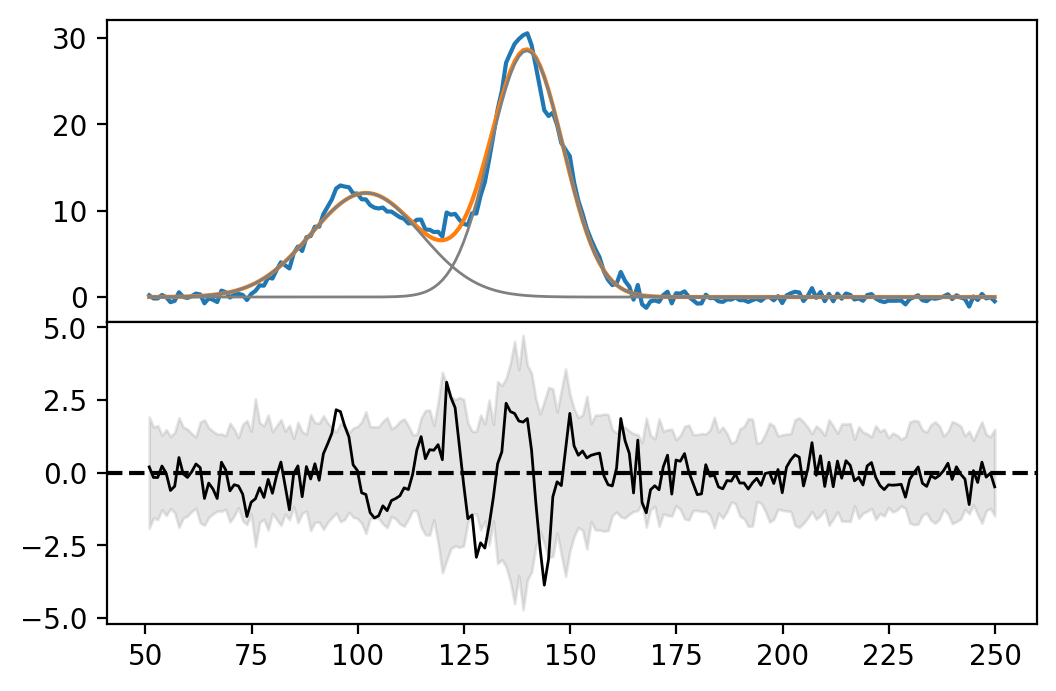

In [11]:
reload(radiative_transfer.Gaussian_fitting)
reload(radiative_transfer)
from radiative_transfer import Gf
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
gf=Gf(x[p],yemi[p],yemi_err[p])
gf.fitting_plot()

0.9999999999999999 2
0.9643248769474209 3


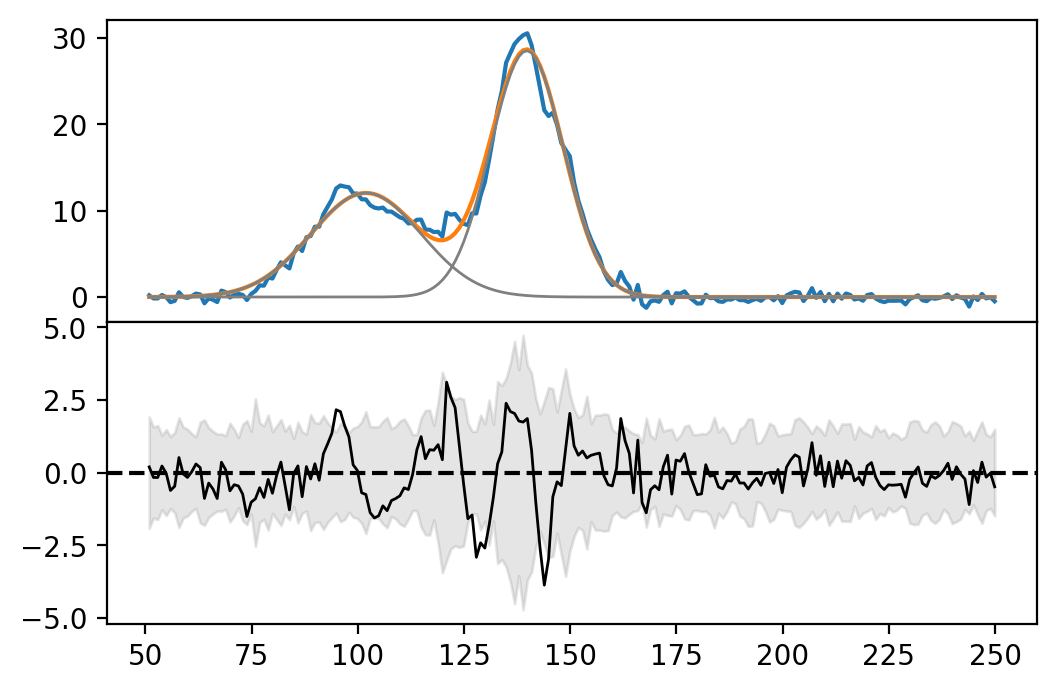

In [12]:
reload(radiative_transfer.Gaussian_fitting)
reload(radiative_transfer)
from radiative_transfer import Gf
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
gf=Gf(x[p],yemi[p],yemi_err[p])
gf.fit_mode= 'F_test'
gf.fitting_plot()

BIC= 85.37740591690289


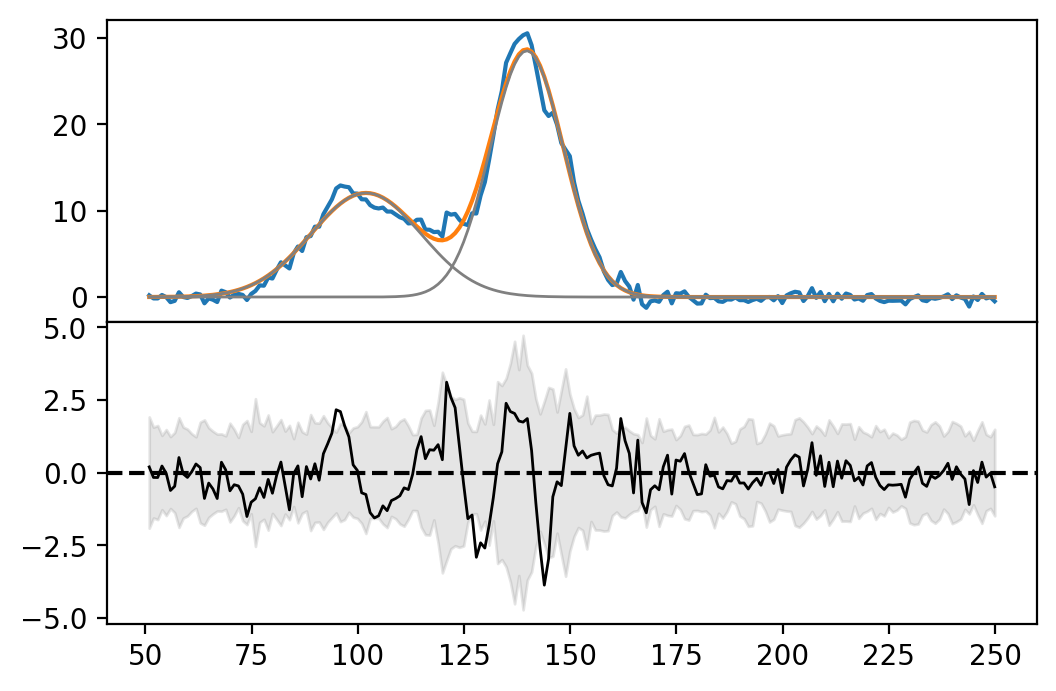

In [13]:
reload(radiative_transfer.Gaussian_fitting)
reload(radiative_transfer)
from radiative_transfer import Gf
a=parse('/d/bip5/hchen/SMC/GASKAP-HI_Pilot_Survey/spectra/J003037-742901_spec.vot')
spectra_abs=a.get_first_table().to_table(use_names_over_ids=True)
x=np.array(spectra_abs['velocity']/1000)
y=np.array(spectra_abs['opacity'])
yerr=np.array(spectra_abs['sigma_opacity'])
yemi=np.array(spectra_abs['em_mean'])
yemi_err=np.array(spectra_abs['em_std'])
p=np.argwhere((x>50)&(x<250)).flatten()
#plt.plot(x[p],yemi[p])
gf=Gf(x[p],yemi[p],yemi_err[p])
gf.x_peak=[150,100]
gf.fitting_plot()



# spectra_decomposing

In [15]:
nemi=np.sort(glob.glob(datapathbase+'/LMC_GASKAP_emi_all_abs/*.txt'))
nabs_n=glob.glob(datapathbase+'/LMC_abs_new/abs_v1.0/sb*')
nabs=[None] * len(nemi)
for i, ni in enumerate(nemi):
    na_=ni[-18:-4]
    for nj in nabs_n:
        _=glob.glob(nj+'/averaged/spectra/*_spec.vot')
        _all=[filename[-23:-9] for filename in _]
        if na_ in _all:
            if nabs[i] is not None:
                print(i,nj,na_)
                break  # Exit the loop once a match is found for this `na_`
            else:
                nabs[i] = f'{nj}/averaged/spectra/{na_}_spec.vot'  # Record `nj` only once for this `na_`
                
nemi,nabs=np.array(nemi),np.array(nabs)  
nlist=[filename[-18:-4] for filename in nemi]
nlist=np.array(nlist)        
nabs=np.array(nabs)  

              

[206]


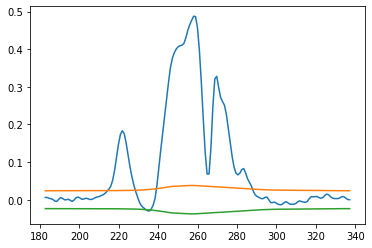

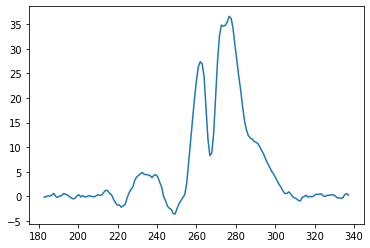

In [51]:
reload(rd)
p=np.argwhere(np.array(nlist)=='J054623-665544').flatten()
print(p)
j=167
x,y,yerr,xemi,yemi,yemi_err,yemi_selferr=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
g = Gaussian1DKernel(stddev=0.8)
plt.plot(x,convolve(y, g))
plt.plot(x,yerr*4)
plt.plot(x,-yerr*4)
plt.figure()
plt.plot(xemi,yemi)
#plt.plot(xemi,yemi_err)

In [23]:
reload(rd)
spectra=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
spectra['TB']

array([-2.84362801e-01, -3.25823398e-01,  5.32361812e-04, -2.01718216e-02,
        1.45123764e-01,  2.22528086e-01,  6.84923313e-02,  5.76403496e-02,
        1.77496829e-01, -2.15507687e-01, -4.74974137e-01, -1.12309447e-01,
       -2.56539987e-01, -2.48955933e-01, -2.64150527e-01, -3.68663378e-01,
       -2.13601732e-01,  9.42053178e-02,  5.65221175e-02, -8.69624706e-02,
       -1.19229908e-02, -1.39899186e-01, -2.47623211e-01,  3.48835020e-02,
        2.83587317e-01,  2.08217345e-01,  2.71341533e-02,  1.05642394e-01,
        2.37858317e-01,  3.74259356e-01,  3.43382205e-01,  6.02764889e-01,
        5.45731118e-01,  6.64811608e-01,  8.12863293e-01,  7.43271937e-01,
        3.52339420e-01,  1.05619597e+00,  1.31286798e+00,  1.51143614e+00,
        1.74748156e+00,  2.60495739e+00,  3.06324551e+00,  3.67474363e+00,
        3.77219070e+00,  4.91219128e+00,  6.09314016e+00,  7.30191617e+00,
        7.98419498e+00,  9.58041184e+00,  1.14262499e+01,  1.32669369e+01,
        1.46003614e+01,  

J050413-700456
BIC  402.21130252923444 n=1
BIC  310.27289793897205 n= 2
BIC  259.2649555294754 n= 3
BIC  265.0733122140706 n= 4
3 0.20417943635428643
final n= 3 noise level= 0.20417943635428643
final BIC= 259.26494791478353
[227.94407759 247.28015033 233.79465018]
BIC= 378.27155248401994


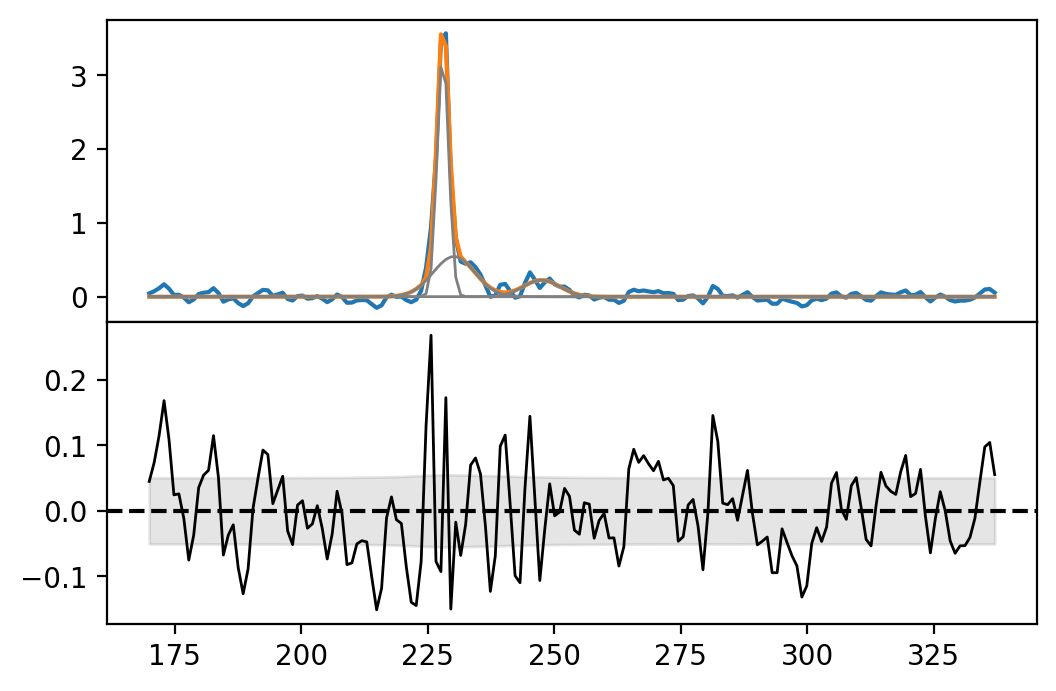

In [65]:
reload(rd)
reload(radiative_transfer.Gaussian_fitting)
reload(radiative_transfer)
from radiative_transfer import Gf
#file_path = "/d/bip5/hchen/output_data/LMC_fitting/long_runs.txt"

# Read the file and create a list of strings (one per line)
#with open(file_path, 'r') as file:
#    lines = [line.strip() for line in file]
p=np.argwhere(np.array(nlist)=='J045153-692328').flatten()
j=50
print(nlist[j])
spectra=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
x,y,yerr,xemi,yemi,yemi_err=spectra['velocity_tau'],spectra['1_e_tau'],spectra['1_e_tau_err'],spectra['velocity_TB'],spectra['TB'],spectra['TB_err']
#Gf.fitting_plot(x,y,yerr,x_peak=[3.12835286e+02,2.61895645e+02+10])
g = Gaussian1DKernel(stddev=0.5)
#Gf.fitting_plot(x,convolve(y, g),yerr)
gf=Gf(x,convolve(y, g),yerr)
gf.bic_weight=20
popt_,pcov_=gf.fitting()
print(popt_[1::3])
if y.max()>=1.:
    print('Satuated')
    p=np.argwhere(y>=0.99).flatten()
    y[p]=y[p]/y.max()*0.99
    #y=y/y.max()-np.exp(-3)
y=-np.log(1-y)

gf=Gf(x,y,yerr)
gf.x_peak=popt_[1::3]
gf.fitting_plot()

#Gf.fitting_plot(x,y,yerr,x_peak=popt_[1::3])

In [82]:
reload(rd)
rd.read_synchro_emi('J054623-665544',radius=120)


(0.051705897, 0.09772658)

J045541-690629 Tsyn (0.82719445, 0.12775758)
BIC  252.8923265105613 n=1
BIC  214.8844350096119 n= 2
BIC  220.50732731671212 n= 3
final n= 2 noise level= 0.1710744639237112
final BIC= 214.8845770855838
[239.14110047 247.97730786]
BIC= 284.2965515049149
popt_ori [1.12480225e+00 2.38947747e+02 2.15778314e+00 2.16891495e-01
 2.45779372e+02 5.49317974e+00]
origin BIC  1757.822444621956 Original_Mean_score  1774.1373686363513
BIC  47.94593658012989 Mean_score  100.4724006823302
BIC  69.9779560576813 Mean_score  106.45910005469253
final BIC  57.94593658012989
47.94593658012989
velocity shift [-0.81103785 -3.1898548 ]



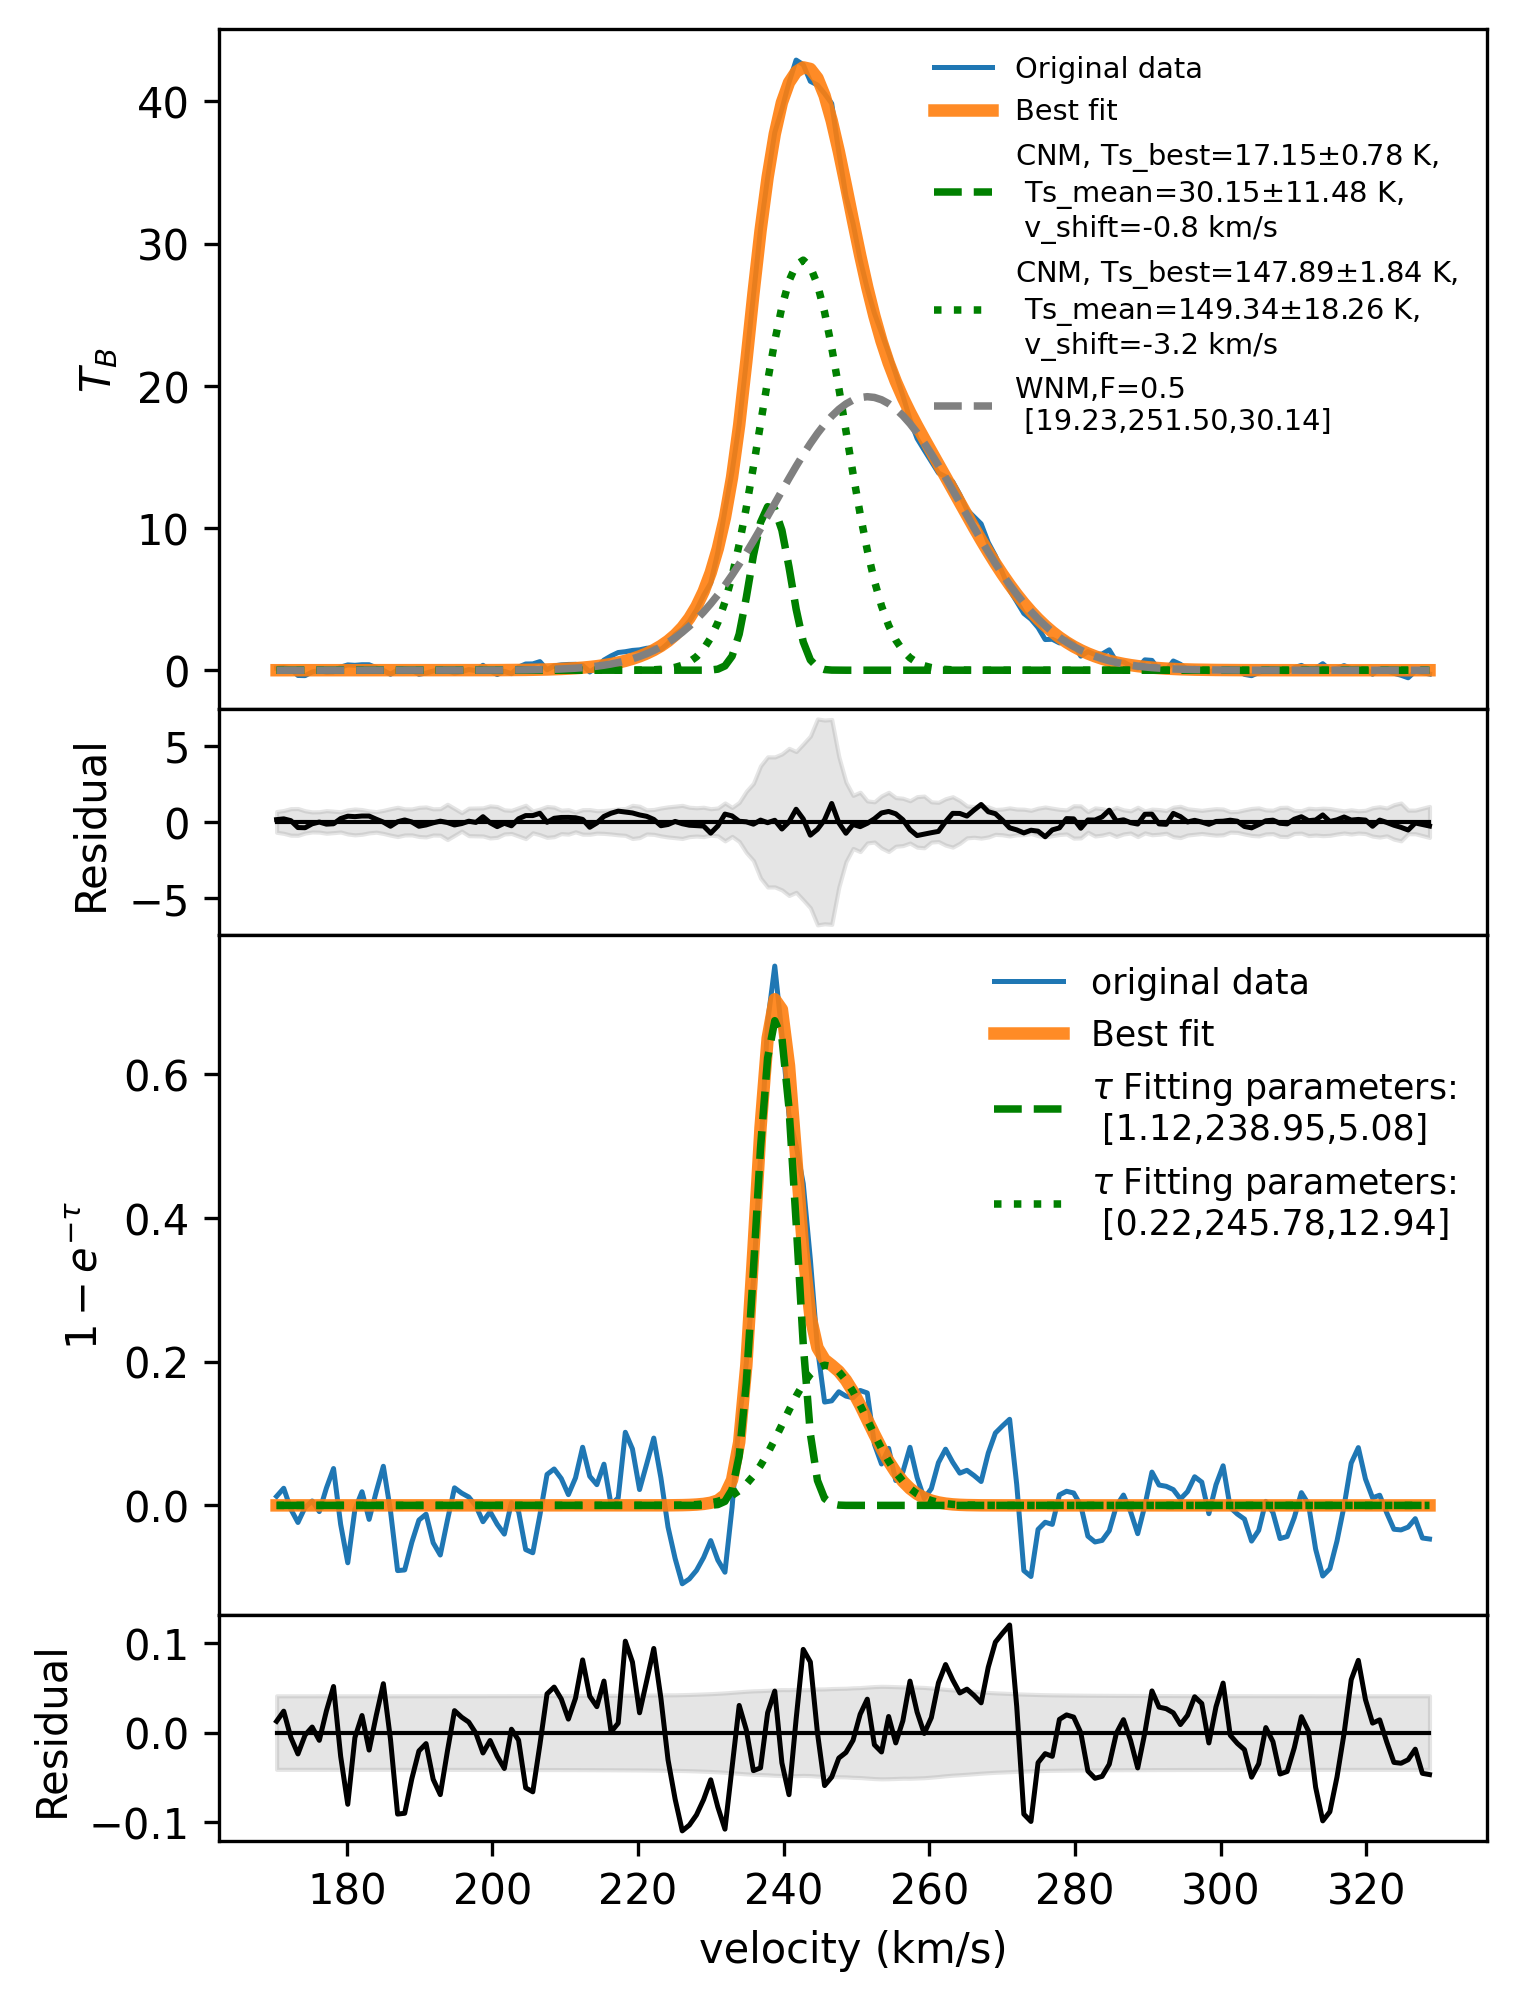

In [ ]:
reload(rd)
reload(radiative_transfer.Gaussian_fitting)
reload(radiative_transfer.spectra_decomposing)
reload(radiative_transfer)
from radiative_transfer import Gf
from radiative_transfer import sd
j=207
p=np.argwhere(np.array(nlist)=='J052456-693855').flatten()
j=30
print(nlist[j],'Tsyn',rd.read_synchro_emi(nlist[j]))

spectra=rd.get_emi_abs_data(nlist[j],nabs[j],1,1,mode='LMC',v_move=0.)
x,y,yerr,xemi,yemi,yemi_err=spectra['velocity_tau'],spectra['1_e_tau'],spectra['1_e_tau_err'],spectra['velocity_TB'],spectra['TB'],spectra['TB_err']

fig = plt.figure(figsize=(12, 8), dpi=300)

ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

ax = [ax1_first,
       plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
       plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
       plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

'''
sd.fit_and_plot(x,y,yerr,xemi,yemi,yemi_err,ax,name=nlist[j],savetxt=False,
                peak_abs=[],peak_emi=[],Tsmin=3.77,
                 fit_mode='BIC',v_sh=4)

'''
tsyn,_=rd.read_synchro_emi(nlist[j])
spec_fit=sd(x,y,yerr,xemi,yemi,yemi_err)
spec_fit.v_shift=4.
spec_fit.peak_abs=[]
spec_fit.peak_emi=[]
spec_fit.Tsmin=2.73
spec_fit.Tsky=2.73+tsyn
spec_fit.savecsv=False
spec_fit.fit_mode='BIC'
spec_fit.ax=ax
spec_fit.datapath=datapathbase + '/output_data/LMC_fitting/'
spec_fit.fit_and_plot()
#fig.savefig(datapathbase + '/output_data/LMC_fitting/plots/%s.png' % (nlist[j]), dpi=300, bbox_inches='tight')


#sd.fit_and_plot(x,y,yerr,xemi,yemi,yemi_err,ax,name=nlist[j],savetxt=True,
#                peak_abs=[],peak_emi=[],Tsmin=3.77,
#                 fit_mode='BIC',v_sh=4)
#fig.savefig(datapathbase + '/output_data/LMC_fitting/plots/%s.png' % (nlist[j]), dpi=300, bbox_inches='tight')


#_p0_1 [236.9321834    3.77         4.09131915 219.66710586   1.        ]
#_p0_1 [236.9321834    3.77         4.09131915 269.50386511   1.        ]
#_p0_1 [236.9321834    3.77         4.09131915 263.64071696   1.        ]
#_p0_1 [236.9321834    3.77         4.09131915 250.93722931   1.        ]

#fig.savefig(datapathbase+'/output_data/LMC_fitting/plots/%s.png'%(nlist[j]), dpi=300, bbox_inches='tight') 

In [2]:
from astropy.coordinates import SkyCoord

def parse_coords(coord_string):
    """
    Convert a coordinate string in the format 'JHHMMSS±DDMMSS' to RA and Dec.

    Parameters:
    coord_string (str): The coordinate string, e.g., 'J053344-721624'.

    Returns:
    tuple: RA (in decimal degrees), Dec (in decimal degrees)
    """
    # Add colons between the components to make it parseable
    ra = coord_string[1:3] + 'h' + coord_string[3:5] + 'm' + coord_string[5:7] + 's'
    dec = coord_string[7:10] + 'd' + coord_string[10:12] + 'm' + coord_string[12:] + 's'
    
    # Create a SkyCoord object with formatted RA and Dec
    coords = SkyCoord(ra + ' ' + dec, frame='icrs')
    
    # Get RA and Dec in decimal degrees
    return coords.ra.degree, coords.dec.degree

# Example usage
coord_string = 'J003037-742903'
ra, dec = parse_coords(coord_string)
print(f"RA: {ra:.6f} degrees, Dec: {dec:.6f} degrees")


RA: 7.654167 degrees, Dec: -74.484167 degrees


In [252]:
import os
import psutil

# Number of logical CPU cores
cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {cpu_cores}")

# Available memory
memory = psutil.virtual_memory()
print(f"Total memory: {memory.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {memory.available / (1024 ** 3):.2f} GB")


Number of CPU cores: 32
Total memory: 250.06 GB
Available memory: 238.81 GB


# Multiple j run_decomposing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.votable import parse
import glob
import sys
import os
import Gaussian_fitting as Gf
import spectra_decomposing as sd
import read_GASKAP_data as rd
import time
from multiprocessing import Process, Queue

datapathbase = '/d/bip5/hchen'


def delete_csv_txt_files(directory, file='.csv'):
    """
    Deletes all .csv and .txt files in the specified directory.

    Args:
        directory (str): Path to the directory.
    """
    if not os.path.isdir(directory):
        print(f"The directory {directory} does not exist.")
        return

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and filename.endswith(file):
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


def process_iteration(j, queue):
    """Function to handle the processing for each j."""
    try:
        print(f"Processing j={j} (PID: {os.getpid()})")
        x, y, yerr, xemi, yemi, yemi_err, yemi_selferr = rd.get_emi_abs_data(
            nlist[j], nabs[j], 1, 1, mode='LMC', v_move=0.
        )

        fig = plt.figure(figsize=(12, 8), dpi=300)
        ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

        ax = [ax1_first,
              plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

        sd.fit_and_plot(x, y, yerr, xemi, yemi, yemi_err, ax, name=nlist[j], savetxt=True,
                        peak_abs=[], peak_emi=[], Tsmin=3.77,
                        fit_mode='BIC', v_sh=4)

        fig.savefig(datapathbase + '/output_data/LMC_fitting/plots/%s.png' % (nlist[j]), dpi=300, bbox_inches='tight')
        sys.stdout.flush()
        queue.put(None)  # Success
    except Exception as e:
        queue.put(str(e))  # Return the exception as a string

def parallel_processing(j_values, max_concurrent_processes=1, timeout=20):
    """Run multiple `j` processes in parallel with timeout enforcement."""
    results = []
    active_processes = {}  # Track active processes

    while j_values or active_processes:  # Continue until no tasks or active processes
        # Start new processes if we haven't reached the limit
        while len(active_processes) < max_concurrent_processes and j_values:
            j = j_values.pop(0)  # Get the next `j`
            queue = Queue()  # Create a queue for communication
            process = Process(target=process_iteration, args=(j, queue))
            process.start()
            active_processes[j] = (process, queue, time.time())  # Track the process, queue, and start time
            print(f"Started process for j={j}.")

        # Check for timeout or completed processes
        for j, (process, queue, start_time) in list(active_processes.items()):
            elapsed_time = time.time() - start_time

            # Handle timeout
            if elapsed_time > timeout:
                print(f"Timeout for j={j}. Terminating process.")
                process.terminate()  # Forcefully terminate the process
                process.join()  # Wait for cleanup
                results.append((j, "Timeout"))  # Log timeout
                active_processes.pop(j)  # Remove from active processes

            # Handle completed process
            elif not process.is_alive():
                process.join()  # Ensure the process is properly cleaned up
                result = queue.get()  # Get the result from the queue
                if result is None:
                    results.append((j, None))  # Success
                else:
                    results.append((j, result))  # Error
                active_processes.pop(j)  # Remove from active processes

        # Allow other processes to run before checking again
        time.sleep(0.1)

    return results






if __name__ == "__main__":
    directory_to_check = datapathbase + "/output_data/LMC_fitting"

    nemi = np.sort(glob.glob(datapathbase + '/LMC_GASKAP_emi_all_abs/*.txt'))
    nabs_n = glob.glob(datapathbase + '/LMC_abs_new/sb*')
    nabs = [None] * len(nemi)
    for i, ni in enumerate(nemi):
        na_ = ni[-18:-4]
        for nj in nabs_n:
            _ = glob.glob(nj + '/spectra_abs/*')
            _all = [filename[-23:-9] for filename in _]
            if na_ in _all:
                if nabs[i] is not None:
                    break
                else:
                    nabs[i] = f'{nj}/spectra_abs/{na_}_spec.vot'

    nemi, nabs = np.array(nemi), np.array(nabs)
    nlist = np.array([filename[-18:-4] for filename in nemi])
    
    a= glob.glob(datapathbase + '/output_data/LMC_fitting/plots/*.png')
    nfinish=np.array([path[-18:-4] for path in a])
    # Prepare the list of `j` values to process
    j_values = np.where(~np.isin(nlist, nfinish))[0]
    j_values=j_values.tolist()
    j_values=j_values[0:2]
    print(j_values)

    # Timeout and number of concurrent processes
    max_concurrent_processes = 1  # Number of parallel processes
    timeout = 15  # Timeout for each task in seconds

    # Open the file to log long-running iterations
    with open(datapathbase + '/output_data/LMC_fitting/long_runs.txt', 'a') as f:
        results = parallel_processing(j_values, max_concurrent_processes=max_concurrent_processes, timeout=timeout)
        print(results)

        for j, result in results:
            if result == "Timeout":
                print(f"Timeout for j={j}. Logging to long_runs.txt.")
                f.write(f"{nlist[j]}\n")
                f.flush()
            elif result is not None:
                print(f"Error for j={j}: {result}")
                
            else:
                print(f"Successfully processed j={j}.")


[84, 87]
Processing j=84 (PID: 1399974)
BIC  1015.256832825996 n=1
BIC  558.3328583915861 n= 2
Started process for j=84.
BIC  501.39436056233524 n= 3
BIC  449.1185746676771 n= 4
BIC  423.7560951400338 n= 5
BIC  442.592817023564 n= 6
final n= 5
[239.68310495 270.52434468 236.30810164 227.92196548 279.77021617]
BIC= 489.7464694064308
popt_ori [1.65289236e+00 2.39164264e+02 2.95239719e+00 2.69736260e-01
 2.70593456e+02 2.28567549e+00 1.44090862e+00 2.37410545e+02
 1.29396321e+00 7.84662042e-02 2.26967063e+02 5.21658707e+00
 9.40339870e-02 2.79767841e+02 1.32358170e+00]
Ts_low limit [11.620235440404993, 12.268629471469566, 10.130718837432743, 17.76200148740255, 54.37734669657478]
Timeout for j=84. Terminating process.
Processing j=87 (PID: 1400150)
Satuated
Started process for j=87.
BIC  255.0120730684623 n=1
BIC  249.80523808657588 n= 2
BIC  259.14341642002125 n= 3
final n= 2
[233.87127745 242.69236828]
BIC= 561.251739691206
popt_ori [  2.87276991 233.98564528   4.10935922   1.58156131 24

In [16]:
nlist[96:100], 'J051418-673528', np.unique(nlist).shape

(['J051537-672127', 'J051637-723710', 'J051641-714905', 'J051716-702357'],
 'J051418-673528',
 (222,))

In [36]:
a= glob.glob(datapathbase + '/output_data/LMC_fitting/plots/*.png')
nfinish=np.array([path[-18:-4] for path in a])
mismatch_indices = np.where(~np.isin(nlist, nfinish))[0]
mismatch_indices

array([ 22,  84,  87, 102, 114, 116, 117, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221])

# original single run_secomposing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.votable import parse
import glob

import sys,os
import Gaussian_fitting as Gf
#sys.path.append('../Absorption_fitting')
import spectra_decomposing as sd
import read_GASKAP_data as rd
import time
from multiprocessing import Process, Queue

datapathbase='/d/bip5/hchen'


def delete_csv_txt_files(directory,file='.csv'):
    """
    Deletes all .csv and .txt files in the specified directory.

    Args:
        directory (str): Path to the directory.
    """
    # Ensure the directory exists
    if not os.path.isdir(directory):
        print(f"The directory {directory} does not exist.")
        return

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        # Construct the full file path
        file_path = os.path.join(directory, filename)

        # Check if it's a file and has .csv or .txt extension
        if os.path.isfile(file_path) and (filename.endswith(file)):
            try:
                os.remove(file_path)  # Delete the file
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


def process_iteration(j, queue):
    """Function to handle the processing for each j."""
    try:
        print(f"Processing j={j} (PID: {os.getpid()})")
        x, y, yerr, xemi, yemi, yemi_err, yemi_selferr = rd.get_emi_abs_data(
            nlist[j], nabs[j], 1, 1, mode='LMC', v_move=0.
        )

        fig = plt.figure(figsize=(12, 8), dpi=300)
        ax1_first = plt.subplot2grid((8, 2), (0, 0), rowspan=3, fig=fig)

        ax = [ax1_first,
              plt.subplot2grid((8, 2), (3, 0), rowspan=1, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (4, 0), rowspan=3, fig=fig, sharex=ax1_first),
              plt.subplot2grid((8, 2), (7, 0), fig=fig, sharex=ax1_first)]

        sd.fit_and_plot(x, y, yerr, xemi, yemi, yemi_err, ax, name=nlist[j], savetxt=True,
                        peak_abs=[], peak_emi=[], Tsmin=3.77,
                        fit_mode='BIC', v_sh=4)

        fig.savefig(datapathbase + '/output_data/LMC_fitting/plots/%s.png' % (nlist[j]), dpi=300, bbox_inches='tight')
        sys.stdout.flush()
    except Exception as e:
        queue.put(e)  # Send the exception back to the parent process
    finally:
        queue.put(None)  # Signal the completion of the task


if __name__ == "__main__":
    # Example usage
    directory_to_check = datapathbase+"/output_data/LMC_fitting"
    #delete_csv_txt_files(directory_to_check,file='.csv')
    #delete_csv_txt_files(directory_to_check,file='.txt')
    #delete_csv_txt_files(directory_to_check+'/plots',file='.png')
    #idx = int(sys.argv[1])
    #print sources observed twice
    nemi=np.sort(glob.glob(datapathbase+'/LMC_GASKAP_emi_all_abs/*.txt'))
    nabs_n=glob.glob(datapathbase+'/LMC_abs_new/sb*')
    nabs=[None] * len(nemi)
    for i, ni in enumerate(nemi):
        na_=ni[-18:-4]
        for nj in nabs_n:
            _=glob.glob(nj+'/spectra_abs/*')
            _all=[filename[-23:-9] for filename in _]
            if na_ in _all:
                if nabs[i] is not None:
                    #print(i,nj,na_)
                    break  # Exit the loop once a match is found for this `na_`
                else:
                    nabs[i] = f'{nj}/spectra_abs/{na_}_spec.vot'  # Record `nj` only once for this `na_`
                    
    nemi,nabs=np.array(nemi),np.array(nabs)  
    nlist=[filename[-18:-4] for filename in nemi]
    #0-18:original
    #19-84:not change Gaussian fitting
    # Define a timeout handler


# Open the file to log long-running iterations
    with open(datapathbase + '/output_data/LMC_fitting/long_runs.txt', 'a') as f:
        for j in range(87, 222):
            start_time = time.time()

            queue = Queue()
            process = Process(target=process_iteration, args=(j, queue))
            process.start()
            process.join(timeout=30*60)  # Allow 30*60 seconds for processing

            if process.is_alive():
                # Timeout occurred
                print(f"Timeout for j={j}, skipping to next.")
                try:
                    f.write(f"{nlist[j]}\n")  # Record the long-running iteration
                    f.flush()  # Ensure immediate write to disk
                    os.fsync(f.fileno())  # Force file system sync
                except Exception as e:
                    print(f"Error writing to log file: {e}")
                process.terminate()  # Terminate the process
                process.join()  # Ensure the process is fully cleaned up
            else:
                # Check if an error occurred in the process
                result = queue.get()
                if result is not None:
                    print(f"Error processing {nlist[j]}: {result}")

            elapsed_time = time.time() - start_time
            print(f"Elapsed time for j={j}: {elapsed_time:.2f} seconds")
            #print(j,nlist[j],end='\r', flush=True)
            #nohup /bin/python3 run_decompose.py > output.log 2>&1 &
            #ps aux | grep run_decompose.py
            #ls -1 *.png 2>/dev/null | wc -l
            #pkill -f run_decompose.py
                    

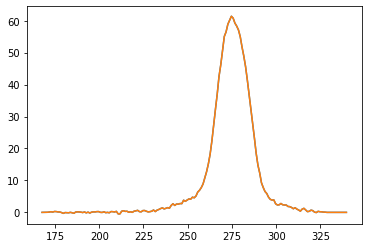

In [272]:
k=23
a = np.loadtxt(f"{datapathbase}/LMC_GASKAP_emi_all_abs/{nlist[k]}.txt")
#x=x-1
xemi=a[:,0]
yemi=a[:,1]
yemi_err=a[:,2]

plt.plot(xemi,yemi)

a = np.loadtxt(f"{datapathbase}/LMC_GASKAP_emi_all/{nlist[k]}.txt")
#x=x-1
xemi=a[:,0]
yemi=a[:,1]
yemi_err=a[:,2]

plt.plot(xemi,yemi)